In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import shutil 
from tqdm import tqdm
import os
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import random
import subprocess

from torchvision import transforms, models

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\Shyam Kadiwar\AppData\Roaming\Python\Python312\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [2]:
SEED = 18
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
data_root = 'C:\shyam\A multiclass disease classifier\data\chest_xray'
print(os.listdir(data_root))

['test', 'train']


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Shyam Kadiwar\AppData\Local\Temp\ipykernel_21704\257308593.py:1: SyntaxWarning: invalid escape sequence '\s'
  data_root = 'C:\shyam\A multiclass disease classifier\data\chest_xray'


In [4]:
train_dir = 'train'
val_dir = 'val'
each_val_img_ind = 50  # Валидация каждое 50-ое изображение будем класть в валидацию

class_names = ['NORMAL', 'PNEUMONIA']

# Создаем директории для train, val и virus
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
    os.makedirs(os.path.join(dir_name, 'virus'), exist_ok=True)  # Создаем папку virus

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if 'virus' in file_name:
            if i % each_val_img_ind != 0:
                dest_dir = os.path.join(train_dir, 'virus')
            else:
                dest_dir = os.path.join(val_dir, 'virus')
        else:
            if i % each_val_img_ind != 0:
                dest_dir = os.path.join(train_dir, class_name)
            else:
                dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
class_names.append('virus')

  0%|          | 0/1341 [00:00<?, ?it/s]

100%|██████████| 3875/3875 [00:05<00:00, 650.63it/s]


In [5]:
!dir train 

 Volume in drive C has no label.
 Volume Serial Number is 52E2-C116

 Directory of c:\shyam\A multiclass disease classifier\training_model\train

18-07-2024  10.59 PM    <DIR>          .
18-07-2024  10.59 PM    <DIR>          ..
18-07-2024  10.59 PM    <DIR>          NORMAL
18-07-2024  10.59 PM    <DIR>          PNEUMONIA
18-07-2024  10.59 PM    <DIR>          virus
               0 File(s)              0 bytes
               5 Dir(s)  343,849,779,200 bytes free


In [6]:
train_transforms = [
    transforms.Compose([
    transforms.Resize((224,224)),   
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.CenterCrop(200),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),          
]

val_transforms = [transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),]

train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir,train_transform)
                                                    for train_transform in val_transforms])


val_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(val_dir,train_transform)
                                                    for train_transform in val_transforms])

# train_dataset = torchvision.datasets.ImageFolder(train_dir, transforms=val_transforms)
# val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)


In [7]:
print("train size : {} val size : {}".format(len(train_dataloader), len(val_dataloader)))

train size : 512 val size : 11


In [8]:
class CustomNeuralNetResNet(torch.nn.Module):
    def __init__(self,outputs_number):
        super(CustomNeuralNetResNet, self).__init__()
#         self.net = models.resnet18(pretrained=False)
        self.net = models.resnet50(pretrained=False)
        
#         self.net = models.resnet101(pretrained=True)
        
#         for param in self.net.parameters():
#             param.requires_grad = False

#         TransferModelOutputs = self.net.fc.in_features
#         self.net.fc = torch.nn.Sequential(
#             torch.nn.Linear(TransferModelOutputs, outputs_number))
#         

    def forward(self, x):
        return self.net(x)

In [9]:
model = CustomNeuralNetResNet(3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
# loss = torch.nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True) # смотреть предыдущие градиенты для лучшей сходимости
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.2)


# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

c:\Users\Shyam Kadiwar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shyam Kadiwar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_weights = None
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
#                     log_probs = torch.nn.functional.log_softmax(preds, dim=1)
#                     loss_value = loss(log_probs, labels)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc
#                 if epoch_loss < best_val_loss:
#                     best_val_loss = epoch_loss
#                     best_val_acc =  epoch_acc
#                     best_model_weights = model.state_dict()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
#     if best_model_weights is not None:
#         torch.save(best_model_weights, 'best_model.pth')
#         print('Best model saved with loss:', best_val_loss, best_val_acc)

    return train_loss, val_loss, train_acc, val_acc


In [11]:
train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


c:\Users\Shyam Kadiwar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [26:53<00:00,  3.15s/it]

train Loss: 0.8054 Acc: 0.6555



100%|██████████| 11/11 [00:19<00:00,  1.79s/it]

val Loss: 0.5883 Acc: 0.6727
Epoch 1/9:



100%|██████████| 512/512 [27:01<00:00,  3.17s/it]

train Loss: 0.6317 Acc: 0.7270



100%|██████████| 11/11 [00:31<00:00,  2.83s/it]

val Loss: 0.6043 Acc: 0.7000
Epoch 2/9:



100%|██████████| 512/512 [30:47<00:00,  3.61s/it]  

train Loss: 0.5948 Acc: 0.7396



100%|██████████| 11/11 [00:25<00:00,  2.31s/it]

val Loss: 0.5704 Acc: 0.7182
Epoch 3/9:



100%|██████████| 512/512 [2:13:20<00:00, 15.63s/it]  

train Loss: 0.5272 Acc: 0.7656



100%|██████████| 11/11 [00:25<00:00,  2.29s/it]

val Loss: 0.6058 Acc: 0.6455
Epoch 4/9:



100%|██████████| 512/512 [25:51<00:00,  3.03s/it]

train Loss: 0.4461 Acc: 0.7998



100%|██████████| 11/11 [00:27<00:00,  2.53s/it]

val Loss: 0.4795 Acc: 0.7545
Epoch 5/9:



100%|██████████| 512/512 [27:45<00:00,  3.25s/it]

train Loss: 0.4218 Acc: 0.8121



100%|██████████| 11/11 [00:25<00:00,  2.30s/it]

val Loss: 0.4832 Acc: 0.7727
Epoch 6/9:



100%|██████████| 512/512 [40:29<00:00,  4.75s/it]   

train Loss: 0.4032 Acc: 0.8182



100%|██████████| 11/11 [00:27<00:00,  2.51s/it]

val Loss: 0.4851 Acc: 0.7818
Epoch 7/9:



100%|██████████| 512/512 [28:14<00:00,  3.31s/it]

train Loss: 0.3907 Acc: 0.8189



100%|██████████| 11/11 [00:26<00:00,  2.42s/it]

val Loss: 0.5083 Acc: 0.8091
Epoch 8/9:



100%|██████████| 512/512 [25:53<00:00,  3.03s/it]

train Loss: 0.3797 Acc: 0.8311



100%|██████████| 11/11 [00:24<00:00,  2.21s/it]

val Loss: 0.4747 Acc: 0.8000
Epoch 9/9:



100%|██████████| 512/512 [28:16<00:00,  3.31s/it]

train Loss: 0.3565 Acc: 0.8332



100%|██████████| 11/11 [00:26<00:00,  2.42s/it]

val Loss: 0.5029 Acc: 0.8273


100%|██████████| 11/11 [00:22<00:00,  2.05s/it]


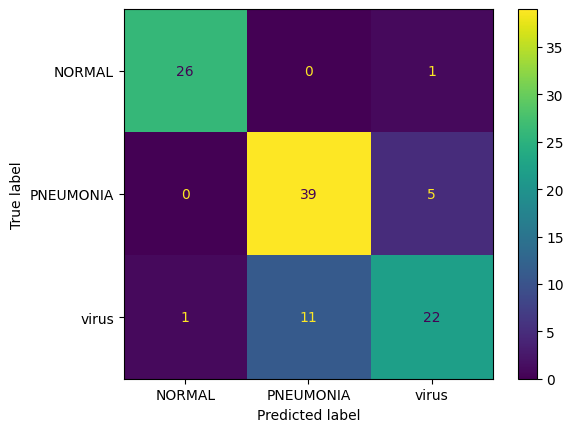

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs)
            preds_class = preds.argmax(dim=1)
            all_preds.extend(preds_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

all_labels, all_preds = evaluate_model(model, val_dataloader)
plot_confusion_matrix(all_labels, all_preds, class_names)

In [16]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_data = 'C:/shyam/A multiclass disease classifier/data/chest_xray/test'
test_dataset = ImageFolderWithPaths(test_data, val_transforms[0])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
def get_predictions(dataloader):
    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(dataloader):
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        # Используем softmax для получения вероятностей классов
        preds = torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()
        test_predictions.append(preds)
        test_img_paths.extend(paths)

    test_predictions = np.concatenate(test_predictions)
    return test_predictions, test_img_paths

test_predictions, test_img_paths = get_predictions(test_dataloader)

100%|██████████| 63/63 [01:19<00:00,  1.25s/it]


In [20]:
# torch.save(model.state_dict(), 'pneumonia_classifier_model.h5')
# # Save model state_dict
torch.save(model.state_dict(), 'pneumonia_classifier_model.pth')

